Extracting Daily confirmed case from the dataset


References:
[1] https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
[2] https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
[3] https://github.com/bhattbhavesh91/adf-test-stationarity-python/blob/master/augmented-dickey-fuller-test-python.ipynb

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
df = pd.read_csv('https://raw.githubusercontent.com/owid/monkeypox/main/owid-monkeypox-data.csv')
df.info()

In [ ]:
df=df[df['location']=='World']
df = df.iloc[:, [2,5]]
df=df.set_index('date')
df['7 day Rolling Average']=df['new_cases'].rolling(window=7).mean()
df['new_cases'].plot(figsize=(18,6))
#df['7 day Rolling Average'].plot(figsize=(18,6))


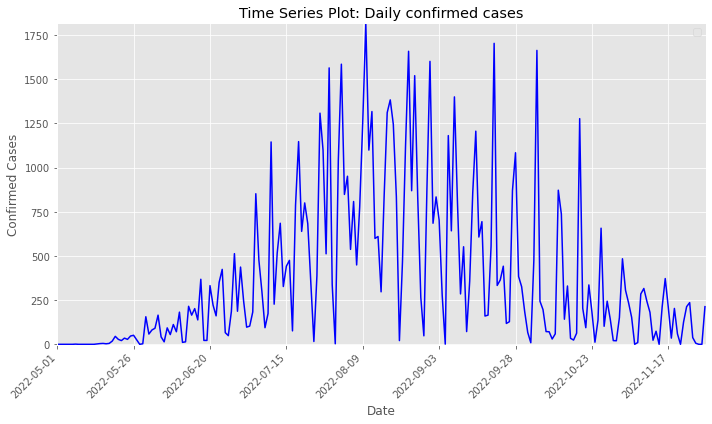

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[0:213],df['new_cases'][0:213], color='blue')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.legend(loc='best')
ax.set(title='Time Series Plot: Daily confirmed cases', xlabel='Date', ylabel='Confirmed Cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("Daily.png", format="png", dpi=1500)

Data Preprocessing for Feeding into Neural Networks

In [ ]:
from numpy import array
data=df['new_cases'].to_numpy() #daily 
data=data[0:213] #Data up to Nov 29 is considered for analysis 
data 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# choose a number of time steps
n_steps = 12 #Window size 
# split into samples
X, y = split_sequence(data, n_steps)
# summarize the data
#for i in range(len(X)):
  #print(X[i], y[i])

In [ ]:
#Dickey Fuller test 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
else:
    print ("Time Series is Non-Stationary")

ADF Statistic: -1.024346
p-value: 0.744281
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Time Series is Non-Stationary


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten


In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# Training and Test data split
X_train=X[0:169]
X_test=X[169:201] #205-32=173 We'll always take last 32 conformed case as our test data 
y_train=y[0:169]
y_test=y[169:201]

99.7293700208759
0.3816031402017894


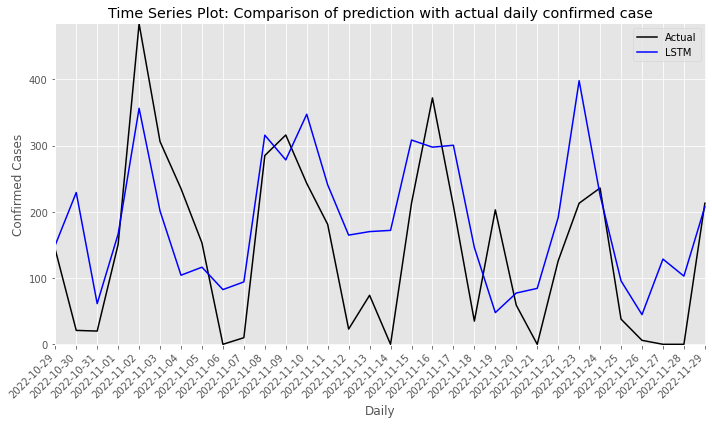

In [ ]:
#Vanilla LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=140,verbose=0)
X_test = X_test.reshape((32, n_steps, n_features))
yhat1 = model.predict(X_test, verbose=0)
#plt.plot(history.history['loss'])
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[181:213], y_test, color='black', label='Actual')
plt.plot(df.index[181:213], yhat1, color='blue', label='LSTM')
ax.legend(loc='best')
ax.set(title='Time Series Plot: Comparison of prediction with actual daily confirmed case', xlabel='Daily', ylabel='Confirmed Cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("LSTM_daily.png", format="png", dpi=1500)
print(sqrt(mean_squared_error(y_test, yhat1)))
print(r2_score(y_test, yhat1))

81.39716136087866
0.5880546134737106


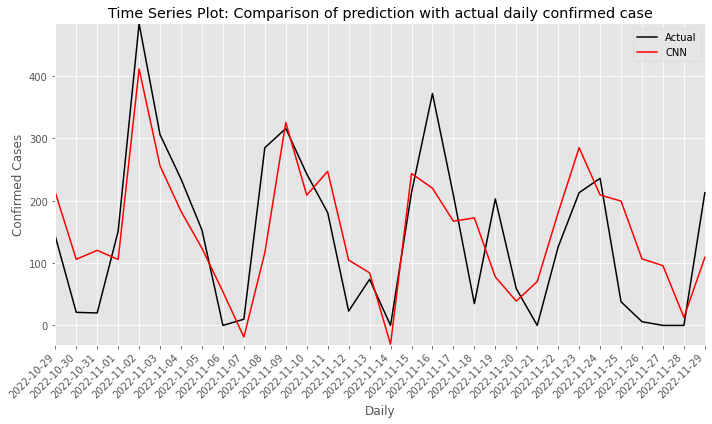

In [ ]:
# CNN
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=1, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=200, verbose=0)
X_test = X_test.reshape((32, n_steps, n_features))
yhat2 = model.predict(X_test, verbose=0)
#plt.plot(history.history['loss'])
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[181:213], y_test, color='black', label='Actual')
plt.plot(df.index[181:213], yhat2, color='Red', label='CNN')
ax.legend(loc='best')
ax.set(title='Time Series Plot: Comparison of prediction with actual daily confirmed case', xlabel='Daily', ylabel='Confirmed Cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("CNN_daily.png", format="png", dpi=1500)
print(sqrt(mean_squared_error(y_test, yhat2)))
print(r2_score(y_test, yhat2))

In [ ]:
#Only for CNN-LSTM
n_features = 1
n_seq = 2
n_steps = 6 #Half of window size 
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
X_train=X[0:169]
X_test=X[169:201]
y_train=y[0:169]
y_test=y[169:201]

77.90058359366641
0.6226863240999438


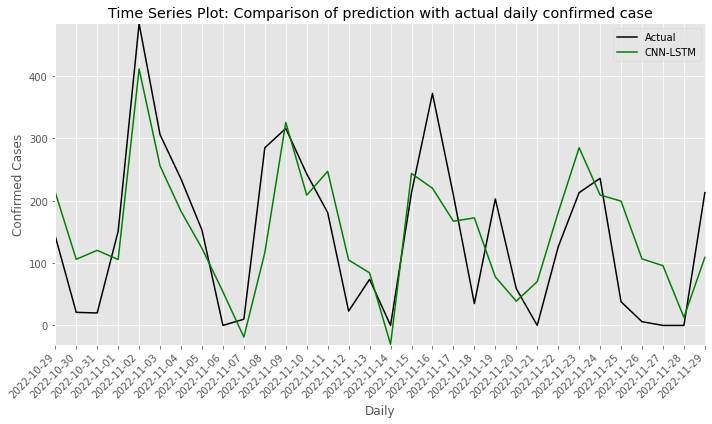

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=200, verbose=0)
X_test = X_test.reshape((32,n_seq, n_steps, n_features))
yhat3 = model.predict(X_test, verbose=0)
#plt.plot(history.history['loss'])
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index[181:213], y_test, color='black', label='Actual')
plt.plot(df.index[181:213], yhat2, color='green', label='CNN-LSTM')
ax.legend(loc='best')
ax.set(title='Time Series Plot: Comparison of prediction with actual daily confirmed case', xlabel='Daily', ylabel='Confirmed Cases')
ax.margins(0.001, tight=True) 
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.savefig("CNNLSTM_daily.png", format="png", dpi=1500)
print(sqrt(mean_squared_error(y_test, yhat3)))
print(r2_score(y_test, yhat3))